# Multimodal Embedding Using FAISS, Node2Vec, and Self-Attention

### 🎯 Objectives
This notebook demonstrates experience in retrieving arguments and discussions from online forums (e.g., Reddit) using a combination of graph-based reasoning and dense text embeddings. The notebook is split into several parts:

**Part 1 & 2: Text Embedding & Graph Representation**
- Extract structured discussion data from Pushshift (a Reddit archive).
- Construct text embeddings using Sentence Transformers.
- Store dense embeddings in FAISS (a scalable vector database).
- Represent text embeddings as a graph using similarity to connect nodes.

**Part 3 & 4: Node Embedding**
- Build graph embeddings for discussions using a Graph Neural Network (GNN).
- Improve on node embeddings using Node2Vec.

**Part 5 & 6: Multimodal Embeddings**
- Concatenate text embeddings and node embeddings
- Fuse multimodal embeddings using self-attention

### 📊 Results 
- The final product of this notebook is a variety of embedding sets, each different way to represent our original data. This embeddings include:
    - Sentence embeddings generated by `all-MiniLM-L6-v2`
    - GNN node embeddings
    - Node2Vec embeddings
    - Multimodal (Node2Vec + Sentence) self-attention based embeddings
    - Multimodal (Node2Vec + Sentence) self-attention based embeddings enhanced
- See the notebook `./notebooks/embedding_comparison.ipynb` for t-SNE visualization of all our embeddings sets.
- See the notebook `./notebooks/retrieval_agumented_generation` for a RAG implementation and comparison using all our embedding sets.

### ⚙️ Setup
- Remember to set `subreddit_name` to the name of your subreddit since multiple scripts rely on that file notation.

---

## Part 0: Load Data
* Use data from: https://www.reddit.com/r/pushshift/comments/1itme1k/separate_dump_files_for_the_top_40k_subreddits/
* Use torrent to download one or more subreddits of your choosing.
* You can use the script in `./scripts/json_to_csv.py` to convert the files to csv if they are downloaded as in JSON format.
* You can use the script in `./scripts/zst_to_csv.py` to convert the files to csv if they are downloaded as ZSTs.

**NOTE:** Remember to run using the GPU!

### Check GPU Usage
**NOTE:** Remember to run using the GPU

In [1]:
import torch

# Check if CUDA-enabled GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Device Count: {torch.cuda.device_count()}")
else:
    print("GPU is not available. Using CPU.")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print(f"Torch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

GPU is available!
GPU Name: NVIDIA GeForce RTX 4070 SUPER
Device Count: 1
Using device: cuda
Torch version: 2.6.0+cu126
CUDA version: 12.6


### Global Parameters

In [2]:
epochs = 30 # Number of epochs for training on all models
subreddit_name = "AITAH"  # You can change this to any subreddit name
debugging_mode = False # Set to True for debugging mode, uses a smaller dataset

### Load Data

In [3]:
import pandas as pd

# Input comments from a CSV file
input_file = fr"..\data\{subreddit_name}\csv\{subreddit_name}_comments.csv"

df = pd.read_csv(input_file)
df = df.dropna()
df = df.reset_index()

print(f"Dataframe shape: {df.shape}")

Dataframe shape: (100000, 6)


In [4]:
# Keep only the first 100000 comments if testing
if debugging_mode:
    df = df.head(100000)

### Create Folders

In [5]:
import os

# Create the responses directory if it doesn't exist
os.makedirs(f"../data/{subreddit_name}/embeddings", exist_ok=True)
os.makedirs(f"../data/{subreddit_name}/faiss", exist_ok=True)
os.makedirs(f"../data/{subreddit_name}/graphs", exist_ok=True)
os.makedirs(f"../data/{subreddit_name}/models", exist_ok=True)
os.makedirs(f"../data/{subreddit_name}/responses", exist_ok=True)
os.makedirs(f"./figures/{subreddit_name}", exist_ok=True)

## Part 1: Text Embedding

### Embed Comments 
Using all-MiniLM-L6-v2 sentence transformer model to compute embeddings.

In [6]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Compute embeddings for the comments using SentenceTransformer
print("Conmputing embeddings...")
sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
sentence_embeddings_tensor = sentence_transformer_model.encode(df['body'], convert_to_tensor=True)

# Print embedding vector total and dimension
print(f"Embedding total vectors: {sentence_embeddings_tensor.shape[0]}")
print(f"Embedding vector dimension: {sentence_embeddings_tensor.shape[1]}")

# Convert embeddings to numpy (FAISS requires float32)
print("Converting to numpy..")
sentence_embeddings_np = sentence_embeddings_tensor.cpu().numpy().astype('float32')
np.save(f"..\data\{subreddit_name}\embeddings\sentence_embeddings.npy", sentence_embeddings_np)

Conmputing embeddings...
Embedding total vectors: 100000
Embedding vector dimension: 384
Converting to numpy..


### FAISS
- Build a FAISS index of vector embeddings. FAISS enables fast similarity searches over our embeddings.
- Use inner product as a similarity metric.
- Find the `k` nearest neighbors for each vector in our embedding space.
- Produces NumPy array `D` containing similarity scores for each pair
- Produces NumPy array `I` containing indices of `k` nearest neighbors in FAISS index

In [7]:
import faiss

# Create FAISS index tp index ourembeddings. Used in for similarity search
index = faiss.IndexFlatIP(sentence_embeddings_np.shape[1])  # Inner product (cosine similarity)
index.add(sentence_embeddings_np)

# Save the FAISS index to a file
faiss.write_index(index, rf"..\data\{subreddit_name}\faiss\all-MiniLM-L6-v2_faiss.index")
print("FAISS index saved successfully.")

FAISS index saved successfully.


In [8]:
# Perform a search for the top 10 most similar posts for each post
k = 10  # Number of nearest neighbors to retrieve
D, I = index.search(sentence_embeddings_np, k)

## Part 2: Graph Represention

### Create Graph
- Nodes are post IDs of comments in our data with an attribute `body` which is the comment text.
- For each node, `k` edges are created between the given node and the `k` most similar embeddings. Each edge has a weight equal to its similarity score.

In [9]:
import networkx as nx
print("NetworkX version: " + nx.__version__)

# Store results in a DataFrame in graph form
similarity_results = []
G = nx.Graph()

# Add nodes and edges to the graph based on similarity results
print("Building graph...")
for i in range(len(df)):
    post_id = df.iloc[i]['index']
    G.add_node(post_id, text=df.iloc[i]['body'])
    similar_posts = []
    for j in range(1, k):  # Exclude self-match
        similar_post_id = df.iloc[I[i, j]]['index']
        similarity_score = D[i, j]
        similar_posts.append((similar_post_id, similarity_score))
        G.add_edge(post_id, similar_post_id, weight=similarity_score)
    similarity_results.append({"post_id": post_id, "similar_posts": similar_posts})

# Summarize structure of graph
print("Graph summary:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

NetworkX version: 3.4.2
Building graph...
Graph summary:
Number of nodes: 100000
Number of edges: 726450


In [10]:
import pickle

# save the graph
pickle.dump(G, open(rf"..\data\{subreddit_name}\graphs\graph.pickle", 'wb'))
similarity_df = pd.DataFrame(similarity_results)

# Save this in case that you need to do recomputation
similarity_df.to_json(rf"..\data\{subreddit_name}\faiss\faiss_similar_posts.json", orient="records", lines=True)
print("Saved similarity results")

Saved similarity results


### Create PyG Data Object
A PyG Data object is a reformatted version of our graph used for training.

In [11]:
from torch_geometric.data import Data

# Convert Graph to PyTorch Geometric Data Format

# Create a mapping from node identifiers in G to consecutive indices
node_to_index_mapping = {node: i for i, node in enumerate(G.nodes())}

# Build an edge list using the mapping (each edge as a pair of indices)
edge_list_array = np.array([(node_to_index_mapping[u], node_to_index_mapping[v]) for u, v in G.edges()])

# Convert text embeddings to a PyTorch tensor
node_features_tensor = torch.tensor(sentence_embeddings_np, dtype=torch.float)

# Create the connectivity (edge_index) tensor in the required shape [2, num_edges]
connectivity_tensor = torch.tensor(edge_list_array.T, dtype=torch.long)

# Create a PyG Data object from the node features and graph structure
# X, is the node feature matrix (embeddings)
# edge_index, is the graph connectivity (edges) in COO format
graph_data = Data(x=node_features_tensor, edge_index=connectivity_tensor)

## Part 3: GNN Node Embedding
Implements and trains a simple Graph Neural Network (GNN) using PyTorch Geometric to update node features (or embeddings) based on the structure of a graph.
- Define the architecture of a Graph Neural Network.
- Define training routine

### Architecture & Training

In [12]:
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.optim as optim
import time

# Define GNN Model for Node Embeddings
class GNN(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128, output_dim=384):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

def train_gnn(model, data, epochs=20):
    model.train()
    
    # Create a list to store loss values
    loss_history = []
    
    # Record start time
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.x)  # Unsupervised training
        
        # Store loss value
        loss_history.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        epoch_time = time.time() - epoch_start
        # print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Time: {epoch_time:.2f}s")
    
    # Calculate total training time
    total_training_time = time.time() - start_time
    print(f"Total training time: {total_training_time:.2f} seconds")
    
    return out, loss_history, total_training_time

### Initialize Model

In [13]:
# Initialize the GNN model
gnn_model = GNN(input_dim=384, hidden_dim=128, output_dim=384)
optimizer = optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

### Train Model

Total training time: 21.20 seconds


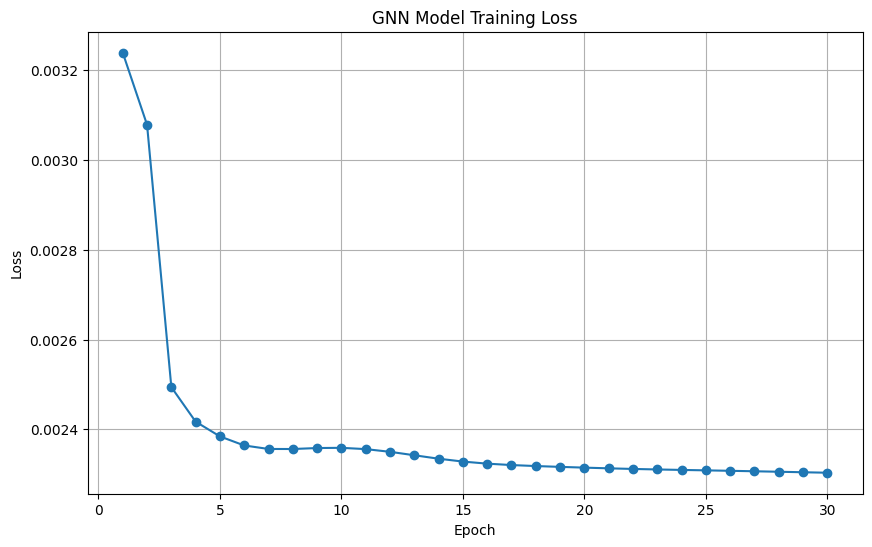

In [14]:
import matplotlib.pyplot as plt

# Train and obtain new node embeddings:
# The model is trained to reconstruct the input embeddings (unsupervised learning) 
# using the nodes and their connectivity in the graph. Connecvtivity is defined by the edges in the graph
# which happen to be the similarity scores between the posts.
# The output embeddings are the learned representations of the nodes with contextual information from the graph structure.
gnn_node_embeddings_tensor, gnn_loss_history, gnn_training_time = train_gnn(gnn_model, graph_data, epochs=epochs)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), gnn_loss_history, marker='o')
plt.title('GNN Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f'./figures/{subreddit_name}/gnn_model_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the trained model's state dictionary (learned parameters) to a file
torch.save(gnn_model.state_dict(), f"../data/{subreddit_name}/models/gnn_model.pt")

In [15]:
# Convert embeddings to numpy (FAISS requires float32)
print("converting to numpy")
gnn_node_embeddings_np = gnn_node_embeddings_tensor.cpu().detach().numpy().astype('float32')
np.save(f"../data/{subreddit_name}/embeddings/gnn_embeddings.npy", gnn_node_embeddings_np)

# Node embeddings size
print(f"Node embeddings total vectors: {gnn_node_embeddings_np.shape[0]}")
print(f"Node embeddings vector dimension: {gnn_node_embeddings_np.shape[1]}")

converting to numpy
Node embeddings total vectors: 100000
Node embeddings vector dimension: 384


## Part 4: Node2Vec Node Embedding

### Training

In [16]:
import time

# Training function
def train_node2vec(model, loader, optimizer, epochs=20):
    model.train()
    loss_history = []
    epoch_times = []
    
    # Record overall start time
    total_start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        total_loss = 0
        
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            # Move data to device
            pos_rw = pos_rw.to(device)
            neg_rw = neg_rw.to(device)
            
            # Calculate loss
            loss = model.loss(pos_rw, neg_rw)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Calculate average loss for this epoch
        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        
        # Print progress
        # print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")
    
    # Calculate total training time
    total_training_time = time.time() - total_start_time
    print(f"Total training time: {total_training_time:.2f} seconds")
    
    # Get the node embeddings after training
    return model.embedding.weight.data, loss_history, total_training_time

### Initialize Model

In [17]:
from torch_geometric.nn import Node2Vec

# Define Node2Vec parameters
embedding_dim = 384  # Match your original embedding dimension
walk_length = 10     # Length of each random walk
context_size = 5    # Context window size for optimization
walks_per_node = 10  # Number of walks per node
num_negative_samples = 1  # Number of negative samples per positive sample
p = 1.0  # Return parameter (1 = neutral)
q = 1.0  # In-out parameter (1 = neutral)
batch_size = 128  # Batch size for training

# Initialize Node2Vec model
node2vec_model = Node2Vec(
    edge_index=graph_data.edge_index,
    embedding_dim=embedding_dim,
    walk_length=walk_length,
    context_size=context_size,
    walks_per_node=walks_per_node,
    num_negative_samples=num_negative_samples,
    p=p,
    q=q,
    sparse=True
).to(device)

### Train Model

Training Node2Vec model...
Total training time: 134.15 seconds


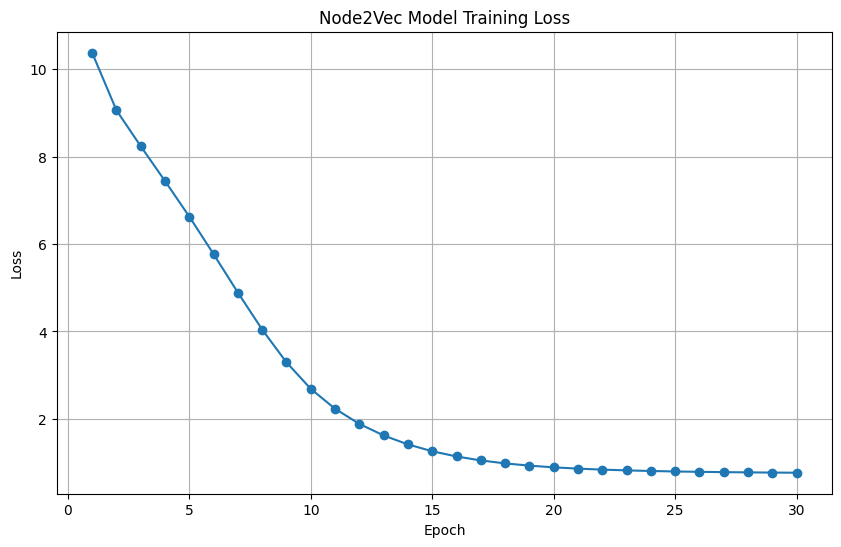

In [18]:
# Initialize optimizer
optimizer = torch.optim.SparseAdam(node2vec_model.parameters(), lr=0.01)

# Create the dataloader for Node2Vec
loader = node2vec_model.loader(batch_size=batch_size, shuffle=True)

# Train the model
print("Training Node2Vec model...")
node2vec_node_embeddings_tensor, node2vec_loss_history, node2vec_training_time = train_node2vec(node2vec_model, loader, optimizer, epochs=epochs)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), node2vec_loss_history, marker='o')
plt.title('Node2Vec Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f'./figures/{subreddit_name}/node2vec_model_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Save embeddings
torch.save(node2vec_model.state_dict(), f"../data/{subreddit_name}/models/node2vec_model.pt")
node2vec_node_embeddings_np = node2vec_node_embeddings_tensor.cpu().detach().numpy().astype('float32')
np.save(f"../data/{subreddit_name}/embeddings/node2vec_embeddings.npy", node2vec_node_embeddings_np)

## Part 5: Multimodal Concatenated Embedding
Combining text and graph representation into a single embedding space.

In [19]:
# Check dimensions before concatenation
print(f"Sentence embeddings shape: {sentence_embeddings_tensor.shape}")
print(f"Node2Vec embeddings shape: {node2vec_node_embeddings_tensor.shape}")

Sentence embeddings shape: torch.Size([100000, 384])
Node2Vec embeddings shape: torch.Size([100000, 384])


### Concatenate embeddings

In [20]:
# Simple concatenation
concat_embeddings = torch.cat((sentence_embeddings_tensor, node2vec_node_embeddings_tensor), dim=1)
print(f"Concatenated embeddings shape: {concat_embeddings.shape}")

# Convert to numpy for further processing
concat_embeddings_np = concat_embeddings.cpu().numpy().astype('float32')

# Save the concatenated embeddings
np.save(f"../data/{subreddit_name}/embeddings/concat_embeddings.npy", concat_embeddings_np)

Concatenated embeddings shape: torch.Size([100000, 768])


## Part 6: Multimodal Attenion-Based Fusion Embedding

### Architecture & Training

In [21]:
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F

class EnhancedGNNWithAttention(nn.Module):
    def __init__(self, text_dim, graph_dim, hidden_dim, output_dim, dropout=0.1):
        super(EnhancedGNNWithAttention, self).__init__()
        
        # Encoders
        self.text_encoder = nn.Linear(text_dim, hidden_dim)
        self.graph_encoder = nn.Linear(graph_dim, hidden_dim)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )
        
        # GAT layer with controlled output
        self.gat = GATConv(hidden_dim, hidden_dim // 4, heads=4, dropout=dropout)
        
        # Regularization
        self.dropout = nn.Dropout(dropout)
        
        # Output projection with normalization
        self.output_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),  # Less aggressive than BatchNorm
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, text_emb, graph_emb, edge_index):
        # Basic encoding
        text_encoded = F.relu(self.text_encoder(text_emb))
        graph_encoded = F.relu(self.graph_encoder(graph_emb))
        
        # Node-level attention mechanism
        # Concatenate both modalities to determine attention weights
        concat_features = torch.cat([text_encoded, graph_encoded], dim=1)
        attention_weights = self.attention(concat_features)  # Shape: [num_nodes, 2]
        
        # Apply attention
        attended_features = (text_encoded * attention_weights[:, 0].unsqueeze(1) + 
                           graph_encoded * attention_weights[:, 1].unsqueeze(1))
        
        # Add mild regularization
        attended_features = self.dropout(attended_features)
        
        # Graph neural network processing
        gat_out = self.gat(attended_features, edge_index)
        
        # Add a small residual connection (30%)
        combined = 0.7 * gat_out + 0.3 * attended_features
        
        # Final output projection
        output = self.output_fc(combined)
        
        return output

In [22]:
class SimpleGNNWithAttention(nn.Module):
    def __init__(self, text_dim, graph_dim, hidden_dim, output_dim):
        super(SimpleGNNWithAttention, self).__init__()
        # Projection layers for text and graph embeddings
        self.text_fc = nn.Linear(text_dim, hidden_dim)
        self.graph_fc = nn.Linear(graph_dim, hidden_dim)
       
        # Attention mechanism using GAT
        # Set output channels to hidden_dim // 4 so with 4 heads we get hidden_dim output
        self.gat = GATConv(hidden_dim, hidden_dim // 4, heads=4)
       
        # Output layer
        self.output_fc = nn.Linear(hidden_dim, output_dim)
       
        # Attention weights (learnable parameters)
        self.attention_weights = nn.Parameter(torch.ones(2, hidden_dim))
       
    def forward(self, text_emb, graph_emb, edge_index):
        # Project text and graph embeddings into a common space
        text_hidden = F.relu(self.text_fc(text_emb))
        graph_hidden = F.relu(self.graph_fc(graph_emb))
       
        # Compute attention weights
        text_attn = F.softmax(torch.mm(text_hidden, self.attention_weights[0].unsqueeze(1)), dim=0)
        graph_attn = F.softmax(torch.mm(graph_hidden, self.attention_weights[1].unsqueeze(1)), dim=0)
       
        # Apply attention weights
        text_weighted = text_hidden * text_attn
        graph_weighted = graph_hidden * graph_attn
       
        # Combine the weighted representations
        combined = text_weighted + graph_weighted
       
        # Apply graph attention network
        gat_out = self.gat(combined, edge_index)
       
        # Final projection
        output = self.output_fc(gat_out)
       
        return output

In [23]:
# Training function
def train_attention_model(model, text_emb, graph_emb, edge_index, epochs=20):
    model.train()
    
    # Move data to device
    text_emb = text_emb.to(device)
    graph_emb = graph_emb.to(device)
    edge_index = edge_index.to(device)
    
    # Define target (here using text embeddings as target)
    target = text_emb.to(device)
    
    # Track loss history
    loss_history = []
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(text_emb, graph_emb, edge_index)
        
        # Compute loss
        loss = criterion(out, target)
        loss_history.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_time = time.time() - epoch_start
        # print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Time: {epoch_time:.2f}s")

    # Record total training time
    total_training_time = time.time() - start_time
        
    return out, loss_history, total_training_time

### Initialize Model

In [24]:
# Define model parameters
text_dim = sentence_embeddings_tensor.shape[1]  # Dimension of text embeddings
graph_dim = node2vec_node_embeddings_tensor.shape[1]  # Dimension of graph embeddings
hidden_dim = 128  # Hidden dimension for fusion
output_dim = 384  # Output dimension (same as original embeddings for comparison)

# Initialize the enhanced model
enhanced_attention_model = EnhancedGNNWithAttention(text_dim, graph_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(enhanced_attention_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

### Train Model

Training attention-based fusion model...


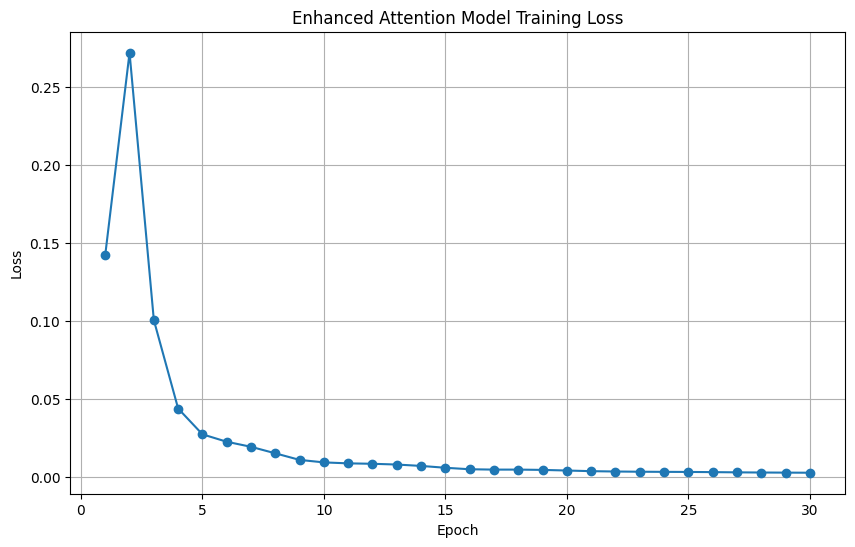

In [25]:
# Train the attention model
print("Training attention-based fusion model...")
enhanced_attention_embeddings, enhanced_attention_loss_history, enhanced_attention_training_time = train_attention_model(
    enhanced_attention_model, 
    sentence_embeddings_tensor, 
    node2vec_node_embeddings_tensor, 
    graph_data.edge_index,
    epochs=epochs
)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), enhanced_attention_loss_history, marker='o')
plt.title('Enhanced Attention Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f'./figures/{subreddit_name}/enhanced_attention_model_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the model and embeddings
torch.save(enhanced_attention_model.state_dict(), f"../data/{subreddit_name}/models/enhanced_attention_model.pt")
enhanced_attention_embeddings = enhanced_attention_embeddings.cpu().detach().numpy().astype('float32')
np.save(f"../data/{subreddit_name}/embeddings/enhanced_attention_embeddings.npy", enhanced_attention_embeddings)

Training attention-based fusion model...


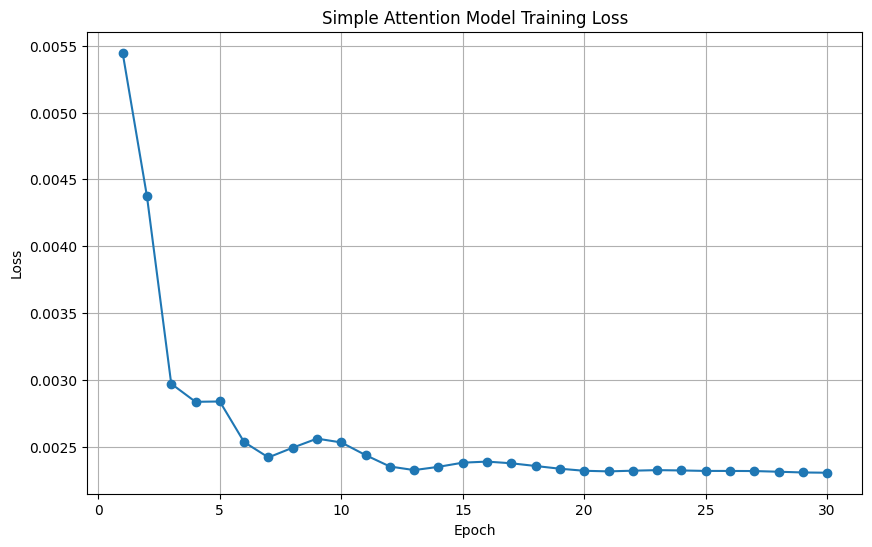

In [26]:
# Initialize the enhanced model
simple_attention_model = SimpleGNNWithAttention(text_dim, graph_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(simple_attention_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train the attention model
print("Training attention-based fusion model...")
simple_attention_embeddings, simple_attention_loss_history, simple_attention_training_time = train_attention_model(
    simple_attention_model, 
    sentence_embeddings_tensor, 
    node2vec_node_embeddings_tensor, 
    graph_data.edge_index,
    epochs=epochs
)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), simple_attention_loss_history, marker='o')
plt.title('Simple Attention Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f'./figures/{subreddit_name}/simple_attention_model_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the model and embeddings
torch.save(simple_attention_model.state_dict(), f"../data/{subreddit_name}/models/simple_attention_model.pt")
simple_attention_embeddings_np = simple_attention_embeddings.cpu().detach().numpy().astype('float32')
np.save(f"../data/{subreddit_name}/embeddings/simple_attention_embeddings.npy", simple_attention_embeddings_np)

## Part 7: Aggregated Plots
- Generate multi-plot loss curve plots
- Compare training time

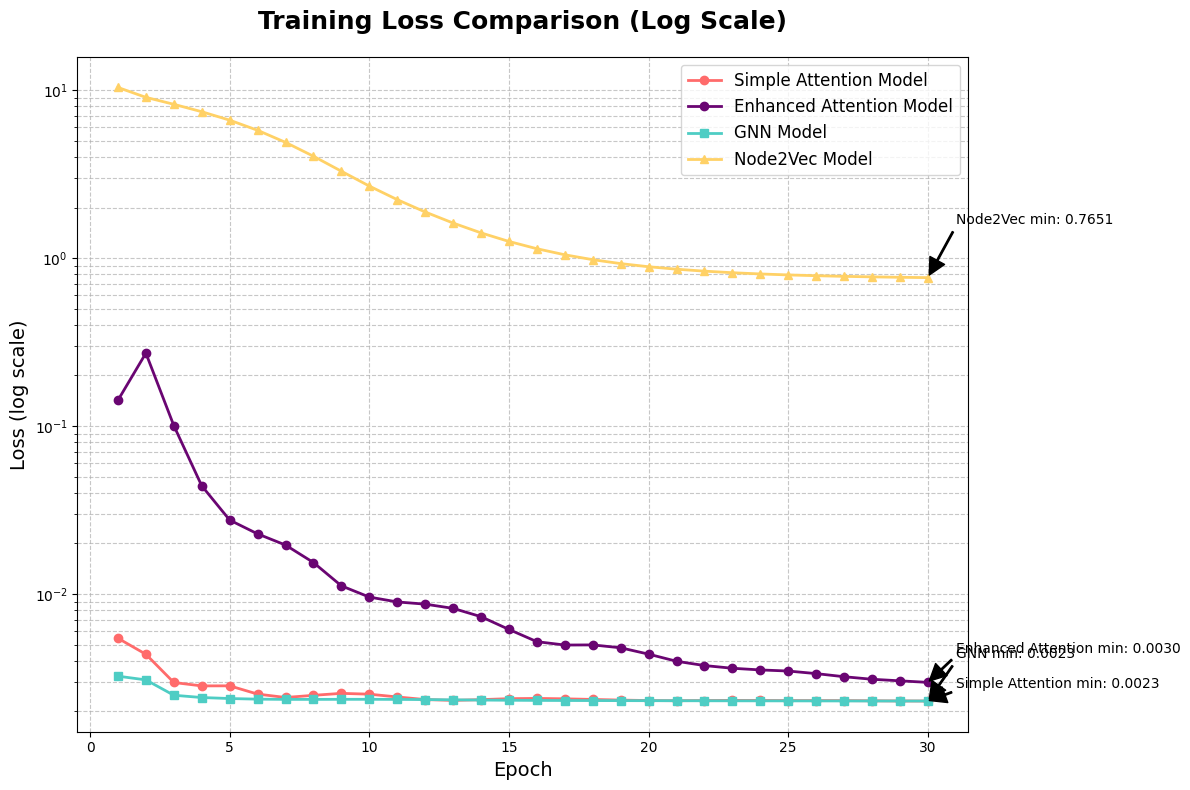

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Plot each loss curve with different colors and line styles
plt.semilogy(range(1, len(simple_attention_loss_history)+1), simple_attention_loss_history,
         'o-', color='#FF6B6B', linewidth=2, markersize=6, label='Simple Attention Model')

plt.semilogy(range(1, len(enhanced_attention_loss_history)+1), enhanced_attention_loss_history,
         'o-', color='#6A0572', linewidth=2, markersize=6, label='Enhanced Attention Model')
         
plt.semilogy(range(1, len(gnn_loss_history)+1), gnn_loss_history,
         's-', color='#4ECDC4', linewidth=2, markersize=6, label='GNN Model')
         
plt.semilogy(range(1, len(node2vec_loss_history)+1), node2vec_loss_history,
         '^-', color='#FFD166', linewidth=2, markersize=6, label='Node2Vec Model')

# Add titles and labels
plt.title('Training Loss Comparison (Log Scale)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (log scale)', fontsize=14)

# Add grid for better readability (with log scale, both x and y grids are helpful)
plt.grid(True, linestyle='--', alpha=0.7, which='both')

# Add legend
plt.legend(fontsize=12, loc='upper right')

# For log scale, annotations need different positioning
for i, (history, name, color) in enumerate([
    (simple_attention_loss_history, 'Simple Attention', '#FF6B6B'),
    (enhanced_attention_loss_history, 'Enhanced Attention', '#6A0572'),
    (gnn_loss_history, 'GNN', '#4ECDC4'),
    (node2vec_loss_history, 'Node2Vec', '#FFD166')
]):
    min_val = min(history)
    min_epoch = np.argmin(history) + 1
    # Adjust vertical position for log scale - use multiplicative offset
    plt.annotate(f'{name} min: {min_val:.4f}',
                xy=(min_epoch, min_val),
                xytext=(min_epoch+1, min_val * (1.2 + i*0.3)),  # Increased vertical spread
                arrowprops=dict(facecolor='black', shrink=0.05, width=1),
                fontsize=10)

# Ensure a tight layout
plt.tight_layout()

# Save the figure
plt.savefig(f'./figures/{subreddit_name}/embedding_models_loss_comparison_log.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

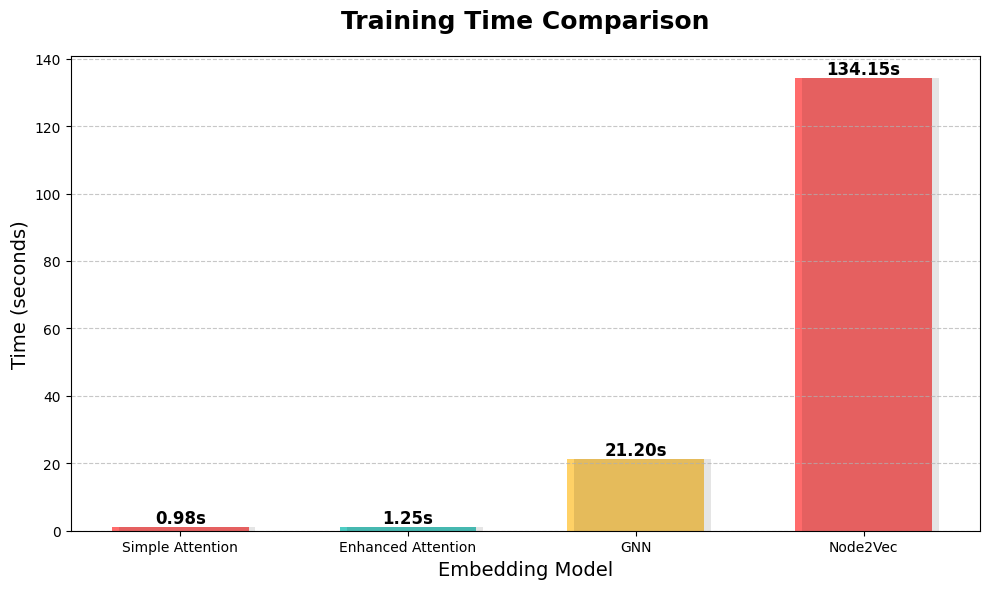

In [28]:
# Create a figure
plt.figure(figsize=(10, 6))

# Set up the data
model_names = ['Simple Attention', 'Enhanced Attention', 'GNN', 'Node2Vec']
training_times = [simple_attention_training_time, enhanced_attention_training_time, gnn_training_time, node2vec_training_time]

# Create the bar graph with custom colors
colors = ['#FF6B6B', '#4ECDC4', '#FFD166']
bars = plt.bar(model_names, training_times, color=colors, width=0.6)

# Add title and labels
plt.title('Training Time Comparison', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Time (seconds)', fontsize=14)
plt.xlabel('Embedding Model', fontsize=14)

# Add grid for the y-axis only
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add exact time values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add a subtle shadow effect to the bars for better aesthetics
for bar in bars:
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    plt.gca().add_patch(
        plt.Rectangle((x+0.03, 0), width, height, 
                     fc='black', alpha=0.1)
    )

# Improve the layout
plt.tight_layout()

# Save the figure
plt.savefig(f'./figures/{subreddit_name}/embedding_models_training_time_comparison.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()